In [1]:
%matplotlib inline

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tools.tools import add_constant
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from time_series_helpers import (to_col_vector,
                                 plot_acf_and_pacf,
                                 PolynomialBasisAndDummyizer)

# Always make it pretty.
plt.style.use('ggplot')

# We get some interger -> float typecast warning from sklean below,
# this keeps them out of our hair.
import warnings
warnings.filterwarnings('ignore')

## Data Exploration

**Q:** First, load the data (the dataset for this exercise is located in
    `data/logins.json`). Pandas has a nice convenient function to read in
    JSON called `read_json()` that returns a data frame.  

In [2]:
this_directory = "/Users/matthew.drury/Solutions/time-series-soln"
os.chdir(this_directory)
logins = pd.read_json(open("./data/logins.json"))

**Q:** The indices should be the timestamps. The values created should be a series of ones so that we can count them. You should convert your data frame so that it looks like this (where the left column is your index):

In [3]:
logins_series = pd.Series(1, index=pd.to_datetime(logins.loc[:, 0]))

**Q:** We would like to resample the data to a daily frequency (and to an hourly frequency for use later).

In [4]:
logins_daily = logins_series.resample('D', 'sum')

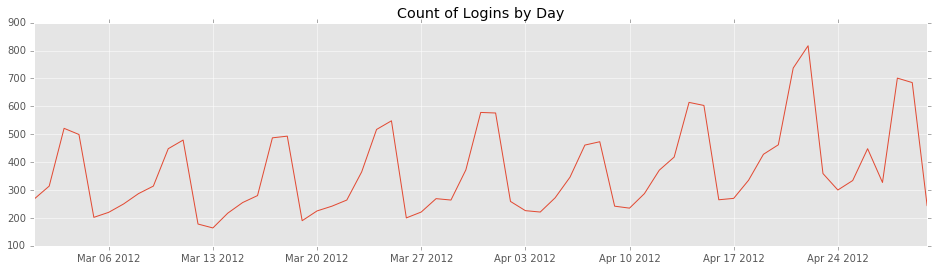

In [5]:
fig, ax = plt.subplots(1, figsize=(16, 4))

ax.plot(logins_daily.index, logins_daily)
ax.set_title("Count of Logins by Day")

In [6]:
logins_hourly = logins_series.resample('H', 'sum')

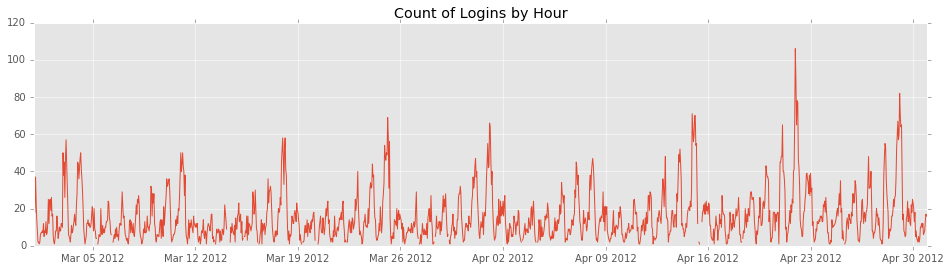

In [7]:
fig, ax = plt.subplots(1, figsize=(16, 4))

ax.plot(logins_hourly.index, logins_hourly)
ax.set_title("Count of Logins by Hour")

**Q:** Before we dive into any statistical or machine learning methods for predicting future data, let's take a look at the data we already have. First just plot the daily data using `.plot()` and see if we can pick out any immediate trends. Zoom in on different time scales and do some exploration to see what you can figure out.

It looks like there could be some structured behaviour in the weeks themselves, i.e. some signal from the day of week.  Let's view a few different weeks.

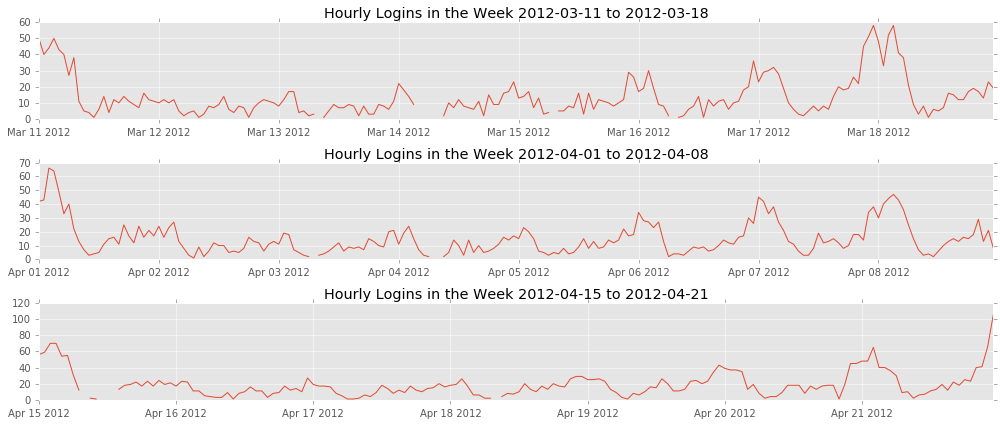

In [8]:
fig, axs = plt.subplots(3, figsize=(14, 6))

begin_dates = ['2012-03-11', '2012-04-01', '2012-04-15']
end_dates = ['2012-03-18', '2012-04-08', '2012-04-21']

for ax, begin_date, end_date in zip(axs, begin_dates, end_dates):
    logins_week = logins_hourly.loc[begin_date:end_date]
    ax.plot(logins_week.index, logins_week)
    ax.set_title("Hourly Logins in the Week {} to {}".format(
        begin_date, end_date))
    
fig.tight_layout()

It seems like there is a pattern in hourly logins within a week:
  - Logins are more common on days nearer the end of the week: Friday, Saturday, and Sunday.
  - Within a day, logins become more common as the day goes on.  They are most common around midnight and least common in the early morning.

**Q:** Create a dataframe that has count and dayofweek features (refer to morning sprint).

In [9]:
logins_df = pd.DataFrame(index=logins_daily.index)
logins_df['count'] = logins_daily
logins_df['day_of_week'] = logins_daily.index.weekday

In [10]:
logins_df.head()

,count,day_of_week
0,,
2012-03-01,268,3
2012-03-02,314,4
2012-03-03,521,5
2012-03-04,499,6
2012-03-05,202,0


**Q:** You should see a strong seasonal component to the data. I'd be willing to bet that the peaks are weekend demand. Let's see if that's true by highlighting the weekends on our plot.

The arithmetic below adds two indicator functions to get an indicator function of the [logical disjunction](https://en.wikipedia.org/wiki/Logical_disjunction).  This is a useful little trick.

In [11]:
is_weekend = (logins_df['day_of_week'] == 5) + (logins_df['day_of_week'] == 6)

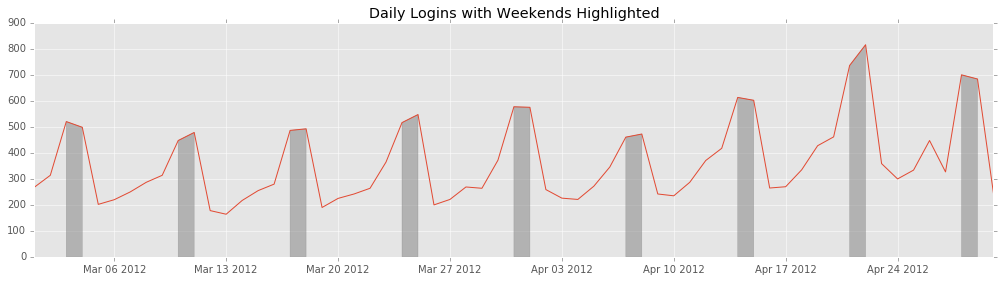

In [12]:
fig, ax = plt.subplots(1, figsize=(14, 4))

ax.plot(logins_df.index, logins_df['count'])
ax.fill_between(logins_df.index, 0, logins_df['count'], 
                where=is_weekend, color='grey', alpha=0.5)
ax.set_title("Daily Logins with Weekends Highlighted")

fig.tight_layout()

## Box Jenkins Methodology

**Q:** Let's turn our attention now to Box-Jenkins. First thing is to determine if the data is stationary. Plot the ACF/PACF with 28 lags (Approx. 4 weeks -- See snippet of code below). Does the data appear to be stationary?

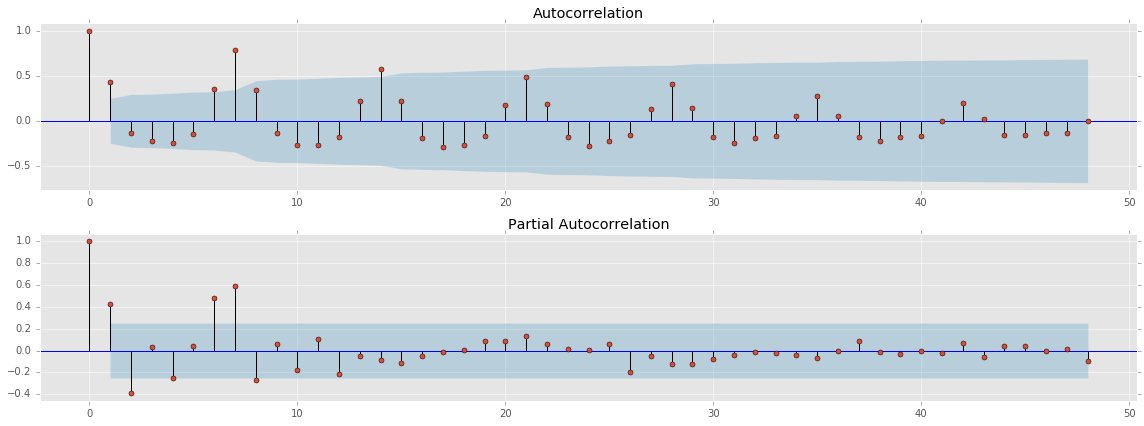

In [13]:
fig, axs = plt.subplots(2, figsize=(16, 6))
plot_acf_and_pacf(logins_daily, axs)
plt.tight_layout()

The most striking feature here is the oscillatory nature of the autocorrelation plot.  This is a clear indication of non-stationarity.

Of course, we should have anticipated this result.  The plot of the series itself shows very clear seasonal (weekly) behaviour.  Stationary series cannot exhibit such behaviour.

**Q:** Hopefully you have found that the data is not stationary, i.e. not constant mean/variance over time. One way to achieve stationarity in the data is to use the differencing function (1st difference can remove linear trend; 2nd order difference can remove curvature, etc).

In some cases with seasonal data, the seasonal difference has to be taken to achieve stationarity, i.e. the difference between this January and the last January if the data is monthly.

Use the `pd.Series.diff(periods=1)` function to take the 1st difference and plot the differenced data and its ACF/PACF

In [14]:
daily_differences = logins_daily.diff(periods=1)

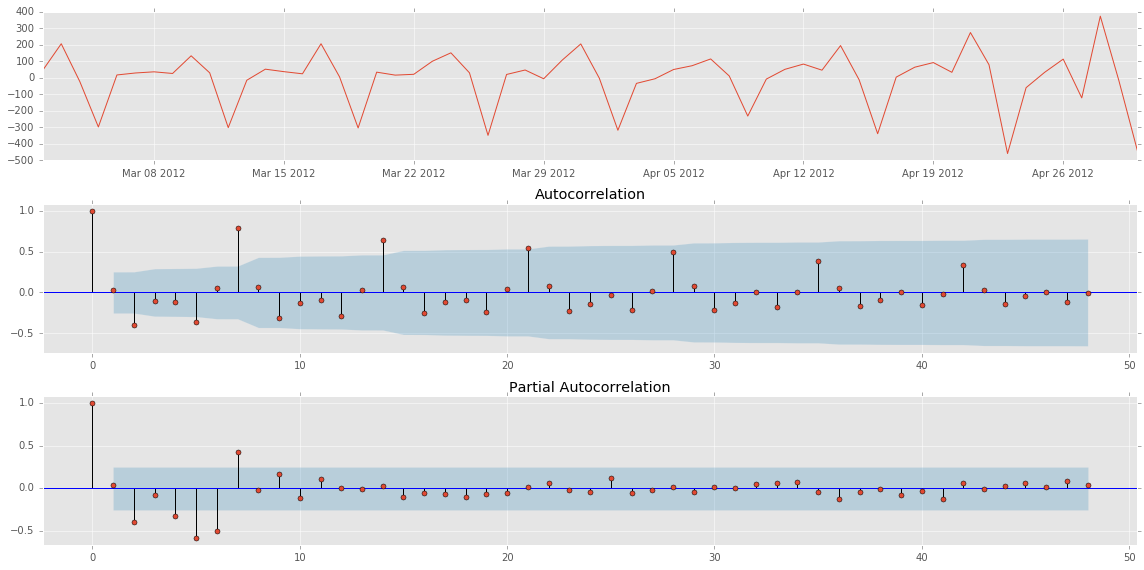

In [15]:
fig, axs = plt.subplots(3, figsize=(16, 8))

axs[0].plot(daily_differences.index, daily_differences)
# The first entry in the differenced series is NaN.
plot_acf_and_pacf(daily_differences[1:], axs[1:])
plt.tight_layout()

The first differencing did *not* result in a stationary series.  This should be expected, the seasonal behaviour causes increases and decreases in the raw series at very regular points in time.

In [16]:
weekly_differences = logins_daily.diff(periods=7)

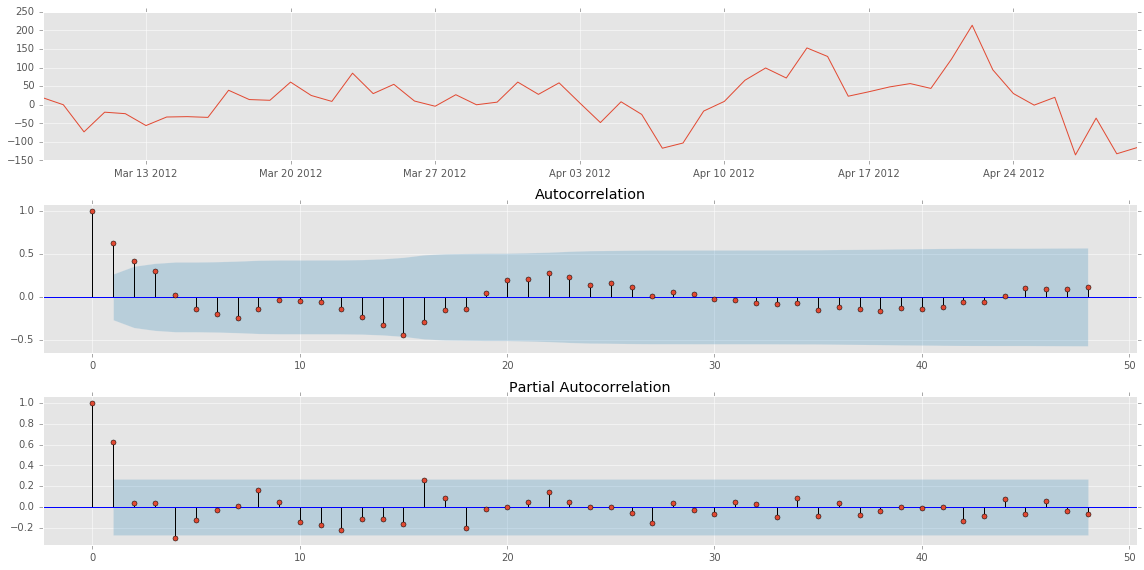

In [17]:
fig, axs = plt.subplots(3, figsize=(16, 8))

axs[0].plot(weekly_differences.index, weekly_differences)
# Now the first full week of entries in NaN.
plot_acf_and_pacf(weekly_differences[7:], axs[1:])
plt.tight_layout()

This looks (possibly) more stationary.  There is only one partial autocorrelaton clearly outside the confidence band.  This is looking like we may have an $AR(1)$ process on our hands.

Let's run a hypothesis test to resolve our dilemma.

In [18]:
test = sm.tsa.stattools.adfuller(weekly_differences[7:])
print("ADF p-value: {0:2.2f}".format(test[1]))

ADF p-value: 0.04


The test confirms our suspicion.  Looking at the p-value in the [Fisherean](https://en.wikipedia.org/wiki/Ronald_Fisher) sense of "strength of evidence", we see not very strong evidence of stationarity.

Let's see if combining a first difference and a seasonal difference yields any better results.

In [19]:
both_differences = logins_daily.diff(periods=1).diff(periods=7)

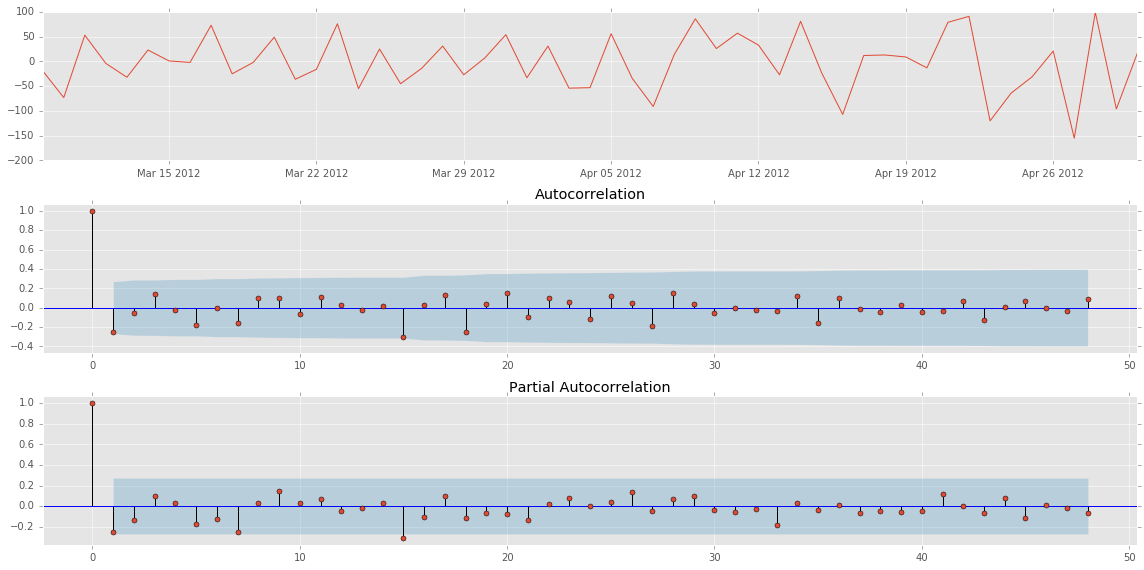

In [20]:
fig, axs = plt.subplots(3, figsize=(16, 8))

axs[0].plot(both_differences.index, both_differences)
plot_acf_and_pacf(both_differences[8:], axs[1:])
plt.tight_layout()

The only concern one may have here is that the variance in the series may increase after April 12th 2012.  There is very little data to support the hypothesis that this is a true effect, so a judgement call here is needed.

There are only three weeks of data in which it looks like the variance may increase, while there are five where the variance looks more or less stable.  Let's cite *Occam's razor* and make the simpler hypothesis that the early behaviour persists, and the variance remains (more or less) constant.

Again, let's ask a hypothesis test to confirm or deny our intuition.

In [21]:
test = sm.tsa.stattools.adfuller(both_differences[8:])
print("ADF p-value: {0:2.2f}".format(test[1]))

ADF p-value: 0.00


Now we are in the clear.

**Q**: Another way to address the changing mean is to detrend the data, which means to use ordinary least square regression (OLS) on the data and treat the residuals as your new time series.

Detrend the data. Plot the detrended data and its ACF/PACF.

In [22]:
X = add_constant(np.arange(1, len(logins_daily) + 1))
y = logins_daily

linear_trend = sm.OLS(y, X).fit().predict(X)

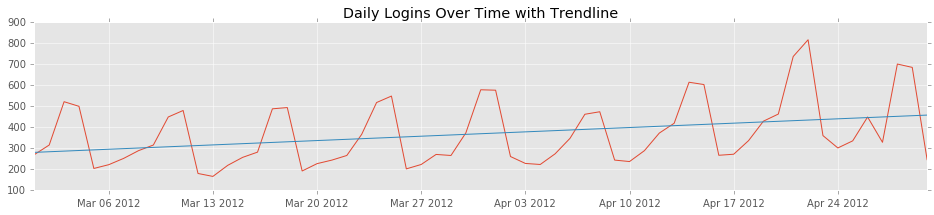

In [23]:
fig, ax = plt.subplots(1, figsize=(16, 3))

ax.plot(logins_daily.index, logins_daily)
ax.plot(logins_daily.index, linear_trend)
ax.set_title("Daily Logins Over Time with Trendline")

This clearly looks terrible, the detrended series has no hope of being stationary.

Let's add some dummy variables to the regression to attempt to capture the seasonal behavior.

In [24]:
dummyizer = PolynomialBasisAndDummyizer(
    poly_spec={}, dummy_list=['day_of_week'])

X_dummies = dummyizer.fit_transform(logins_df)
X = np.column_stack([
        X_dummies,
        add_constant(np.arange(1, len(logins_daily) + 1))
    ])

In [25]:
linear_model_with_dummies = sm.OLS(y, X).fit()
linear_trend_with_dummies = linear_model_with_dummies.predict(X)

You'll notice we used a class of our own design `PolynomialBasisDummyizer` to help transform the data into a form acceptable for our regression model.  We took the thought and trouble to write this into our own class for a couple reasons:

  - The task of dummyizing varaibles and adding polynomial terms generally useful, and we will repeat the process a few times in the rest of the assignment.  It would be very bad practice to repeat the code needed to do this.
  - The task is somewhat delecate and complex.  Encapsulating it in a class gives us one place to look when errors occur.
  - Using a class let's us write out transformer in the style of sklearns `fit` and `transform` API.  This allows our code to mix seamlessly with it's surroundings.  Good code never looks out of place.

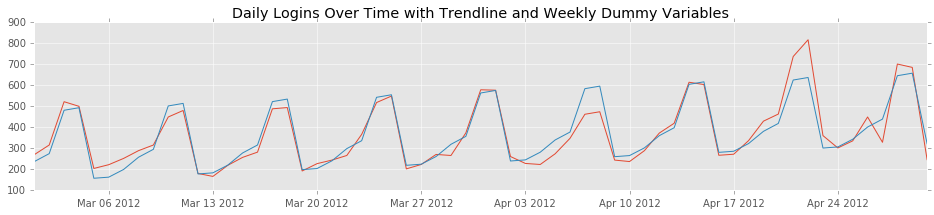

In [26]:
fig, ax = plt.subplots(1, figsize=(16, 3))

ax.plot(logins_daily.index, logins_daily)
ax.plot(logins_daily.index, linear_trend_with_dummies)
ax.set_title("Daily Logins Over Time with Trendline and Weekly Dummy Variables")

That looks, possibly, *too* good.

Let's check out a plot of the residuals.

In [27]:
lm_residuals = pd.Series(
    logins_daily - linear_trend_with_dummies,
    index=logins_daily.index
)

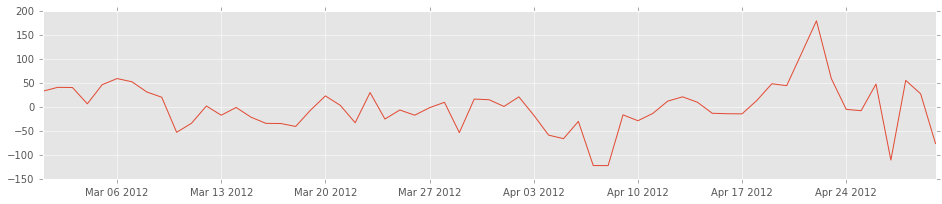

In [28]:
fig, ax = plt.subplots(1, figsize=(16, 3))

ax.plot(lm_residuals.index, lm_residuals)

There are some large deviations in places, and possibly hints of an increasing variance, but overall this residaul plot looks stationary.

Let's check out the ACF and PACF.

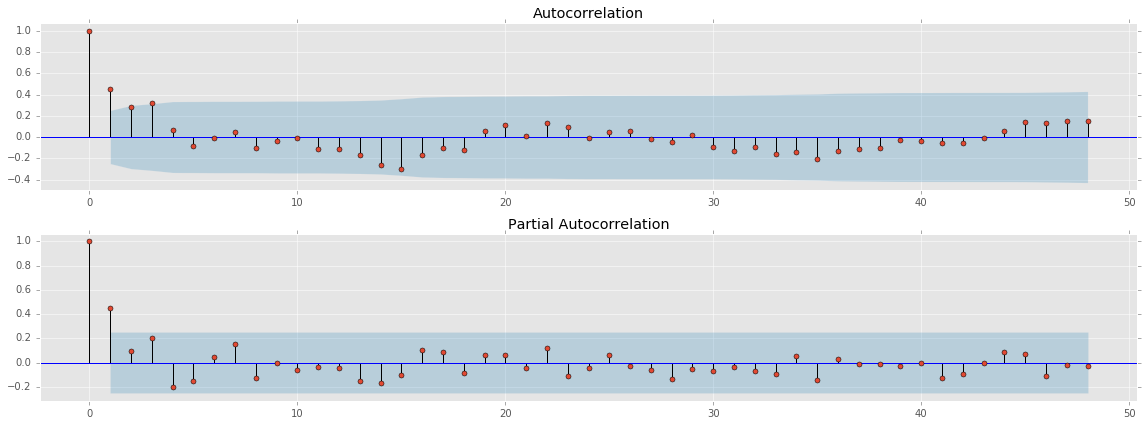

In [29]:
fig, axs = plt.subplots(2, figsize=(16, 6))
plot_acf_and_pacf(lm_residuals, axs)
plt.tight_layout()

Just like with the first and seasonal differencing, we now have almost all of our auto and partial correlations within the confidence bands.

We can wrap things up here with a hypothesis test.

In [30]:
test = sm.tsa.stattools.adfuller(lm_residuals)
print("ADF p-value: {0:2.2f}".format(test[1]))

ADF p-value: 0.00


So, this strategy results in a stationary series as well.

**Q:** Fit a series of seasonal ARIMA models of order `(p,d,q)x(P,D,Q)xL` to the original day data.

We have a few candidate models:

  - A seasonal ARIMA model fit to the first *and* seasonal differenced data.
  - A seasonal ARIMA model fit to the single seasonal differenced data.
  - A seasonal ARIMA model fit to the residuals from the linear regression with day of week dummies.
  
Let's investigate these possibilities.

## First and Seasonal Differences Model

Here's the series and autocorrelation plots for the first and seasonally differenced data.

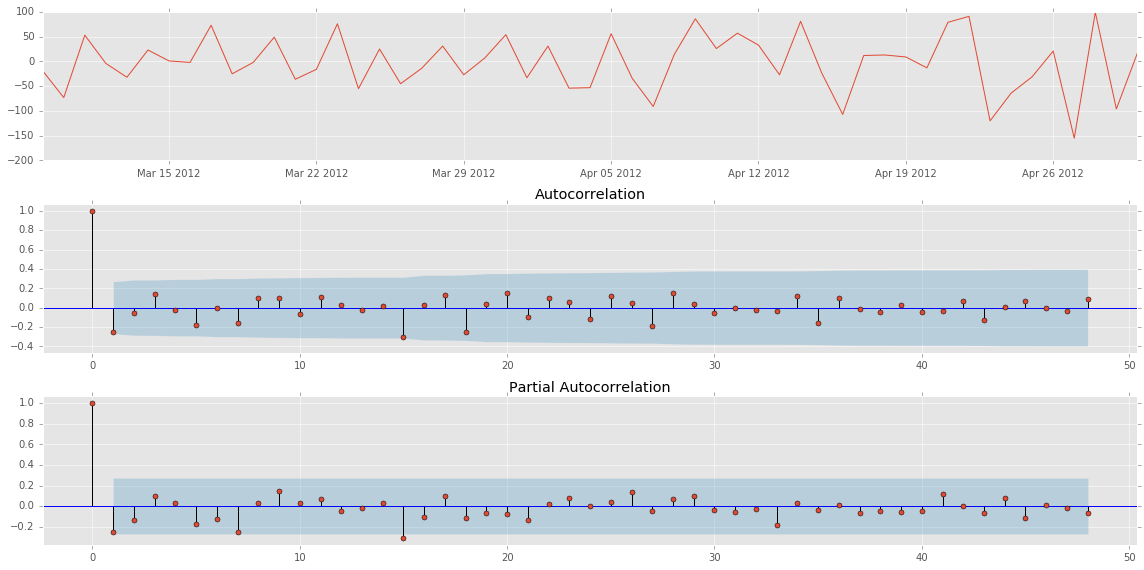

In [31]:
fig, axs = plt.subplots(3, figsize=(16, 8))

axs[0].plot(both_differences.index, both_differences)
plot_acf_and_pacf(both_differences[8:], axs[1:])
plt.tight_layout()

It's debatable whether the initial spikes in the autocorrelation plots are significant, they are both on the boundary.  For the sake of pedagogy, let's assume that the first spike *is* significant.  We see the sharpest decrease subsequent to the fist spike in the autocorrelation plot, so an MA model looks appropriate.

$$ SARIMA(0, 1, 1)(0, 1, 0)_7 $$

In [32]:
double_difference_model = SARIMAX(
    logins_daily,
    order=(0, 1, 1), seasonal_order=(0, 1, 0, 7)).fit()

Let's plot the residuals from this model, and see how they autocorrelate.

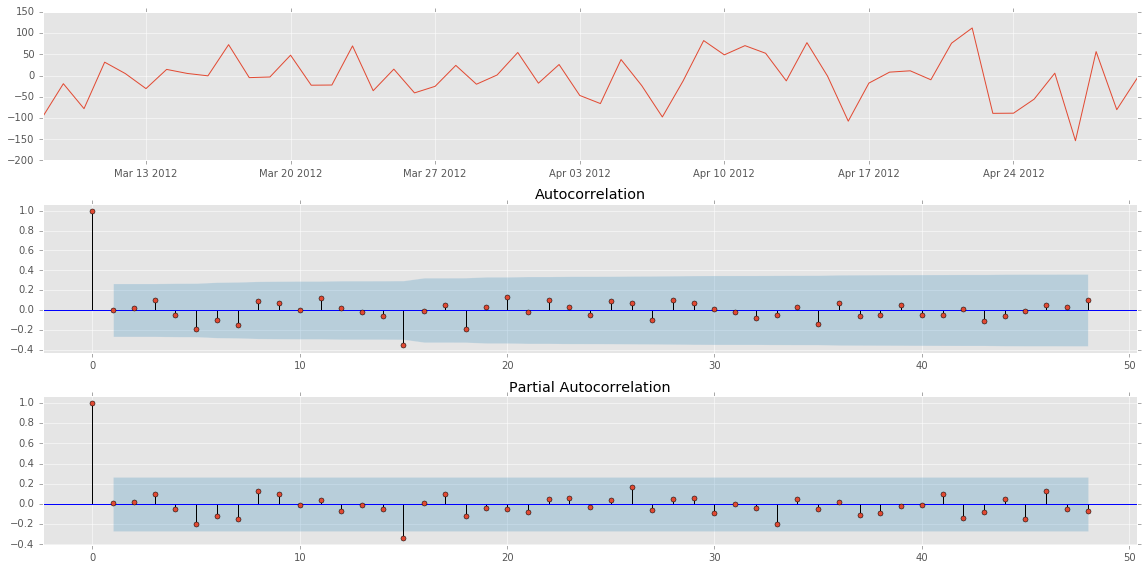

In [33]:
fig, axs = plt.subplots(3, figsize=(16, 8))

# The model predicts zero for the first few datapoints, so the residuals
# are the actual values.
axs[0].plot(double_difference_model.resid.index[7:],
            double_difference_model.resid[7:])
plot_acf_and_pacf(double_difference_model.resid[7:], axs[1:])
plt.tight_layout()

The autocorrelations now look like those from a white noise series, so we're in good shape here.

We can plot the forecasts from this model.

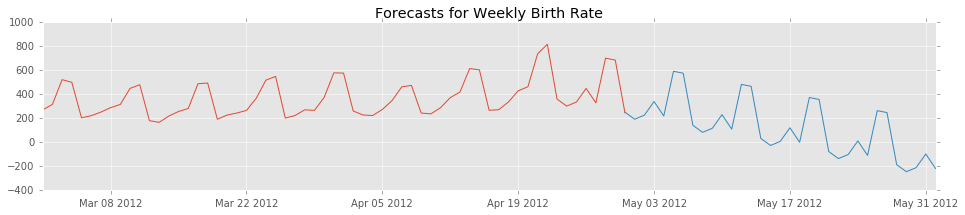

In [34]:
fig, ax = plt.subplots(1, figsize=(16, 3))
ax.plot(logins_daily.index, logins_daily)

preds = double_difference_model.predict(
   logins_daily.index.max(), '2012-06', 
   dynamic=True)

ax.plot(preds.index, preds)
ax.set_title("Forecasts for Weekly Birth Rate")

These do not look reasonable.  The seasonal differencing has recovered the behaviour we wanted, but unfortunately the first differences has caused the model to forecast a severe downward trend in logins, which is not borne out from the data.

Let's investigate some other models.

### Single Seasonal Difference Model

Here's the series and autocorrelation plots for the seasonally differenced data:

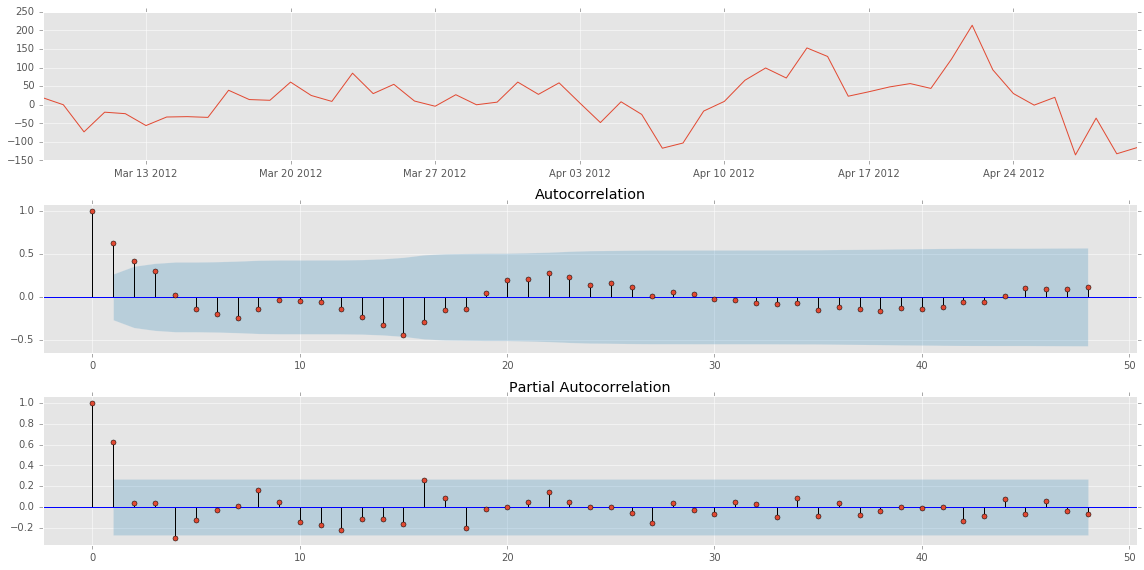

In [35]:
fig, axs = plt.subplots(3, figsize=(16, 8))

axs[0].plot(weekly_differences.index, weekly_differences)
plot_acf_and_pacf(weekly_differences[7:], axs[1:])
plt.tight_layout()

The partial autocorrelation plot shows one significant spike before immediately cutting off.  This points to the need for an AR term in our model, and leads us to a

$$ SARIMA(1, 0, 0)(0, 1, 0)_7 $$

model.

In [36]:
seasonal_difference_model = SARIMAX(
    logins_daily,
    order=(1, 0, 0), seasonal_order=(0, 1, 0, 7)).fit()

Let's check the residuals and see how they correlate:

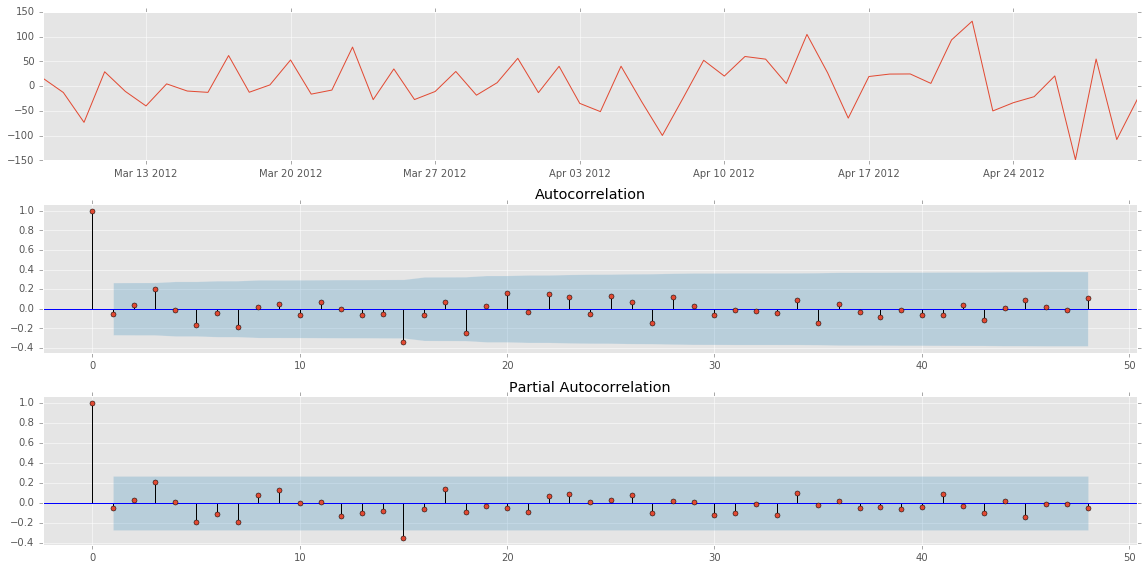

In [37]:
fig, axs = plt.subplots(3, figsize=(16, 8))

# The model predicts zero for the first few datapoints, so the residuals
# are the actual values.
axs[0].plot(seasonal_difference_model.resid.index[7:],
            seasonal_difference_model.resid[7:])
plot_acf_and_pacf(seasonal_difference_model.resid[7:], axs[1:])
plt.tight_layout()

The residuals seem patternless, and the autocorrelation plots validate this suspicion.

Let's make some projections on the original series and see what we've got:

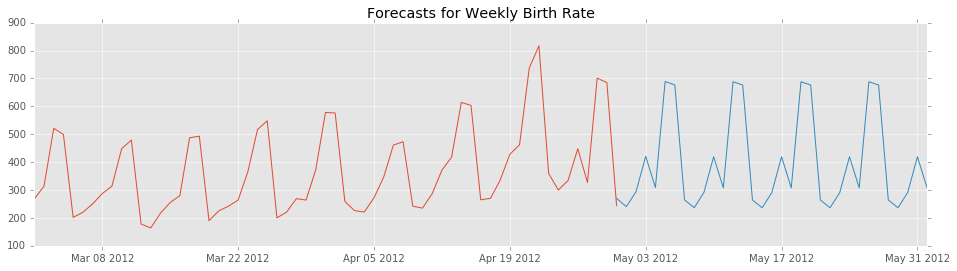

In [38]:
fig, ax = plt.subplots(1, figsize=(16, 4))
ax.plot(logins_daily.index, logins_daily)

preds = seasonal_difference_model.predict(
   logins_daily.index.max(), '2012-06', 
   dynamic=True)

ax.plot(preds.index, preds)
ax.set_title("Forecasts for Weekly Birth Rate")

This model looks much more reasonable than the double differenced model.

We would like to plot some prediction intervals around these forecasts, but the development version of `statsmodels` we are using for the `SARIMAX` function does not support it.

### Model for Residuals from Regression

Let's look at the series, and autocorrelation plots.

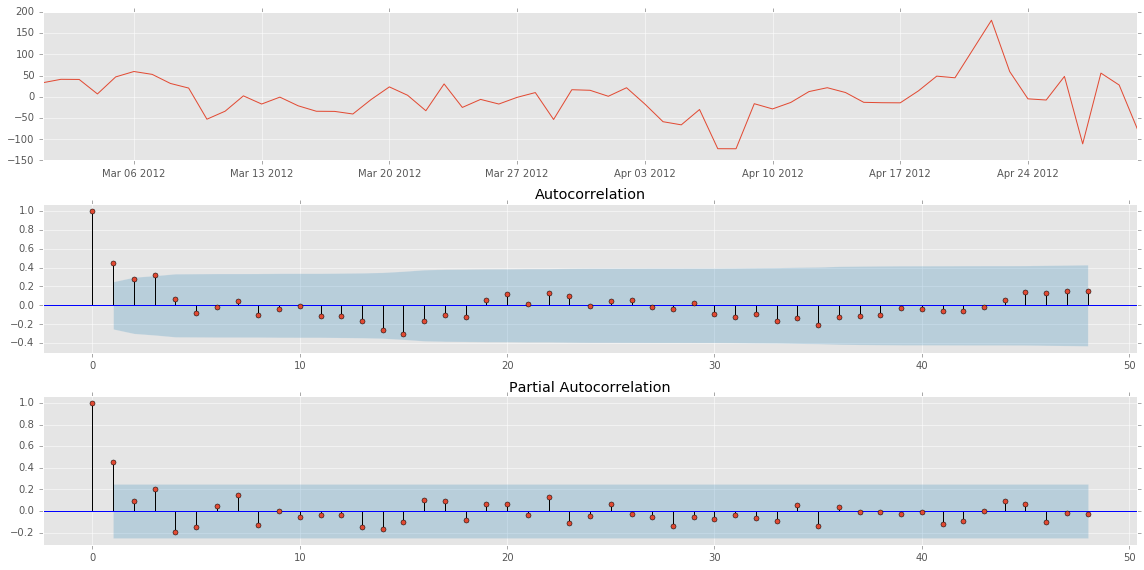

In [39]:
fig, axs = plt.subplots(3, figsize=(16, 8))

# The model predicts zero for the first few datapoints, so the residuals
# are the actual values.
axs[0].plot(lm_residuals.index, lm_residuals)
plot_acf_and_pacf(lm_residuals, axs[1:])
plt.tight_layout()

This is similar to our earlier analysis.  There is exactly one significant spike in the partial autocorrelation plot, pointing us to use an 

$$ ARIMA(1, 0, 0) $$

model on this residual data.

In [40]:
lm_residual_model = ARIMA(
    lm_residuals, order=(1, 0, 0)).fit()

Just like earlier, let's check what the residuals look like.

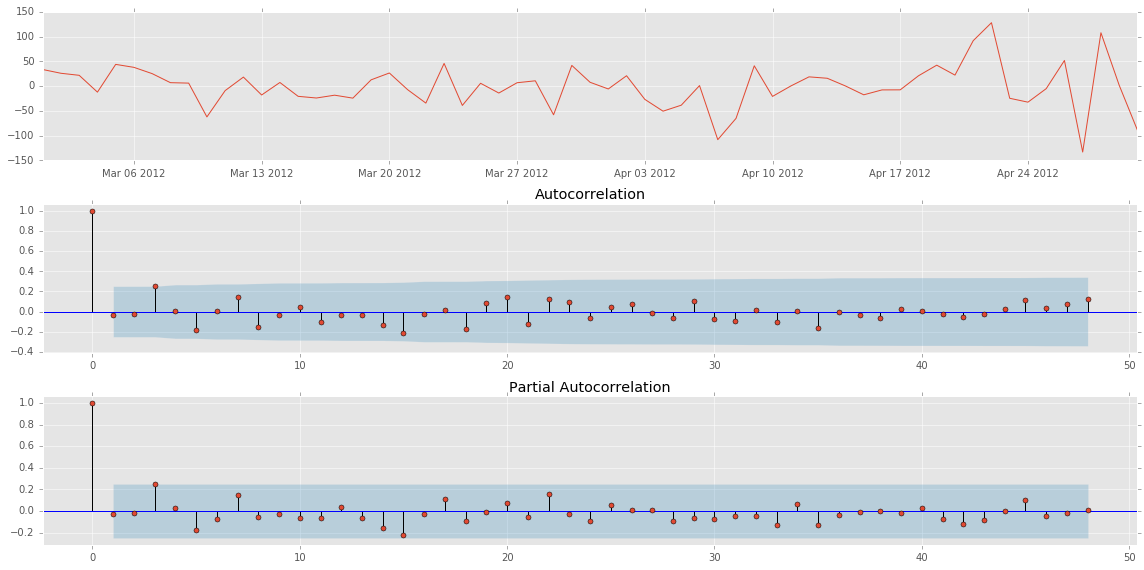

In [41]:
fig, axs = plt.subplots(3, figsize=(16, 8))

axs[0].plot(lm_residual_model.resid.index,
            lm_residual_model.resid)
plot_acf_and_pacf(lm_residual_model.resid, axs[1:])
plt.tight_layout()

The autocorrelation plots show totally insignificant spikes, a good sign.

Let's make some forecasts on the original data, which requires us adding the predictions from the linear model to the predictions from the ARIMA model (remember, the ARIMA model was fit to the *residuals* of the linear model.

In [42]:
# We need this prediction array now, so we can figure out how long
# to make our array of linear model predictions later.
arima_preds = lm_residual_model.predict(logins_daily.index.max(), '2012-06', dynamic=True)

In [43]:
new_index = pd.DatetimeIndex(start=logins_df.index.min(), freq='D', periods=(len(logins_df)+50))
long_df = logins_df.reindex(new_index)

long_df['day_of_week'] = long_df.index.dayofweek

In [44]:
X = np.column_stack([dummyizer.transform(long_df),
                     add_constant(np.arange(1, len(long_df) + 1))])

lm_preds = pd.Series(
    linear_model_with_dummies.predict(X),
    index=long_df.index)

lm_preds= lm_preds[arima_preds.index.min():]

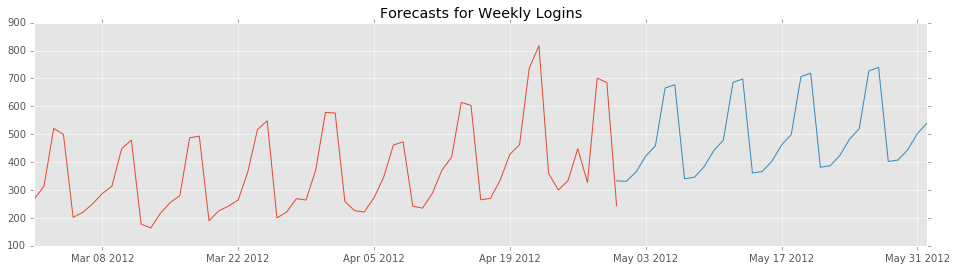

In [45]:
fig, ax = plt.subplots(1, figsize=(16, 4))
ax.plot(logins_daily.index, logins_daily)

ax.plot(lm_preds.index, lm_preds + arima_preds)
ax.set_title("Forecasts for Weekly Logins")

The predictions here are dominated by the linear model.  In fact, if we plot *only* the ARIMA component of the prediction, it's clear their influence is negligible

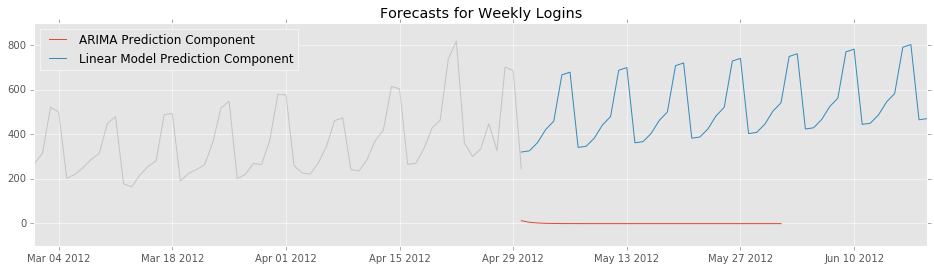

In [46]:
fig, ax = plt.subplots(1, figsize=(16, 4))
ax.plot(logins_daily.index, logins_daily, alpha=0.33, color='grey')

ax.plot(arima_preds.index, arima_preds, label="ARIMA Prediction Component")
ax.plot(lm_preds.index, lm_preds, label="Linear Model Prediction Component")
ax.set_title("Forecasts for Weekly Logins")
ax.legend(loc="upper left")

## Wrap Up

We now have two reasonable candidate models.  At this point, we should proceed by evaluating these models and near by models using fit statistics such as AIC.  Unfortunately, we can not do this naively, for the linear + ARIMA model it is not obvious how to account for the combined degrees of freedom we used in the linear model and the ARIMA model.

This seems like a good avenue for further research.

So, given that, let's wrap up with a search for nearby model's to our single seasonal difference model, based on maximizing AIC.

In [47]:
nearby_parameters = [
    {'AR': 1, 'MA': 0},
    {'AR': 0, 'MA': 1},
    {'AR': 1, 'MA': 1},
    {'AR': 2, 'MA': 0}    
]

In [48]:
results = []
for params in nearby_parameters:
    seasonal_difference_model = SARIMAX(
        logins_daily,
        order=(params['MA'], 0, params['AR']),
        seasonal_order=(0, 1, 0, 7))
    res = seasonal_difference_model.fit()
    results.append(res)

Now we just look at the AIC of these models:

In [49]:
for params, model in zip(nearby_parameters, results):
    print("AIC For Seasonal Difference Model With MA={0}, AR={1}: {2:2.2f}".format(
        params['AR'], params['MA'], model.aic))

AIC For Seasonal Difference Model With MA=1, AR=0: 593.10
AIC For Seasonal Difference Model With MA=0, AR=1: 583.35
AIC For Seasonal Difference Model With MA=1, AR=1: 584.91
AIC For Seasonal Difference Model With MA=2, AR=0: nan


It looks like we had already picked the optimal model, but it's good to have more evidence.